# Execute Custom Quantum Program: Tutorial

This notebook guides you through executing a custom quantum program using **qoolqit**.

> A QuantumProgram combines a Register and a Drive and serves as the main interface for compilation and execution.
>
> Here we will define a register via the DataGraph class of qoolqit and a custom waveform sublassing the Waveform class.

## 1. Create the Register

In [32]:
from qoolqit import DataGraph, Register

#Define a register from a DataGraph
graph=DataGraph.hexagonal(1, 1)
reg=Register.from_graph(graph)

#Define a register from positions
reg=Register.from_coordinates(list(graph.coords.values()))

> Remember it is possible to use prefedined embedders from graphs or define custom ones.
> Refer to the <a href="https://pasqal-io.github.io/qoolqit/latest/contents/available_embedders/"> documentation </a> for this.

## 2. Create a custom Drive

Let us define a profile following the function $f(t) = \Omega_{\mathrm{max}} \cdot \sin^2( \frac{π}{2} \cdot \sin(π t) )$.

In [33]:
import math

from qoolqit.waveforms import Waveform


class SmoothPulse(Waveform):
    """f(t) = omega_max * sin( (π/2) * sin(π t) )^2, for 0 ≤ t ≤ duration"""

    def __init__(self, duration: float , omega_max: float) -> None:
        super().__init__(duration, omega_max=omega_max)

    def function(self, t: float) -> float:
        return self.omega_max * math.sin(0.5 * math.pi * math.sin(math.pi * t/self.duration)) ** 2

## 3. Combine Register and Drive into a Quantum Program

> ⚠️ **Remember**  
> qoolqit always uses **dimensionless units** (<a href="https://pasqal-io.github.io/qoolqit/latest/theory/rydberg_model/"> documentation </a>):  
> - Energies are normalized by the maximum drive amplitude $\Omega_\text{max}=1$.  
> - Time is measured in units of $1/\Omega_\text{max}$ (Rabi oscillations).  
> - Space is measured in units of $r_B=(C_6/\Omega_\text{max})^{1/6}$.  

### 3.a Details about units of measure

> #### Why normalization?  
> All quantum devices have a hardware limit for the **maximum drive strength** they can apply $\Omega_\text{max}$.  
> To make programs device-independent, we take this maximum value as our **unit of energy** and measure every amplitude as a function of it:  
> 
> $$
> \bar{\Omega} = \frac{\Omega}{\Omega_\text{max}}
> $$
> For example:  
> - If the physical maximum is $\Omega_\text{max}=4\pi \,\text{rad/µs}$, then $\bar{\Omega}_\text{max}=1$.  
> - A drive of $\Omega=2\pi \,\text{rad/µs}$ becomes $\bar{\Omega}=0.5$.  
> - A drive of $\Omega=\pi \,\text{rad/µs}$ becomes $\bar{\Omega}=0.25$.  
> 
> This makes all quantum programs **dimensionless** and therefore comparable across devices.  
>
> ---
> 
> #### What happens to other units?
> 
> Normalizing the drive amplitude automatically sets the scale for **time** and **space** as well:  
> 
>
> - **Energy units:**  
>   $$
>   \bar{E} = \frac{E}{\Omega_\text{max}}
>   $$
>   So also the detuning is measured in units of $\Omega_\text{max}$.
> 
>
> - **Time units:**  
>   At zero detuning, the Rabi frequency is equal to the drive,  
>   $$
>   \Omega_R = \Omega_{\text{max}},
>   $$  
>   so the natural unit of time is  
>   $$
>   t_R = \frac{1}{\Omega_\text{max}}.
>   $$  
>   All times are expressed in multiples of the Rabi period at maximum drive $T=\frac{2 \pi}{\Omega_{\text{max}}}=2 \pi t_R$.  
>   $$
>   \bar{t} = \frac{t}{t_R}= \frac{2 \pi t}{T}
>   $$ 
>   So, in a time $\bar{t}=2 \pi$ one gets a full Rabi period.
>
> - **Space units:**  
>   Interactions follow $E(r)=C_6/r^6$.  
>   The characteristic length is defined by setting $E(r_B)=\Omega_\text{max}$:  
>   $$
>   r_B = \left(\frac{C_6}{\Omega_\text{max}}\right)^{1/6}.
>   $$  
>   Distances are expressed relative to $r_B$, i.e. the Rydberg blockade radius at maximum drive.  
>   $$
>   \bar{r} = \frac{r}{r_B}.
>   $$ 
>
> ---
> 
> ### Summary
> - **Energy** → normalized by $\Omega_\text{max}$  
> - **Time** → measured in $1/\Omega_\text{max}$ (Rabi oscillations)  
> - **Space** → measured in $r_B=(C_6 / \Omega_\text{max})^{1/6}$ (interaction length)  


### 3.b Definition of drive and program

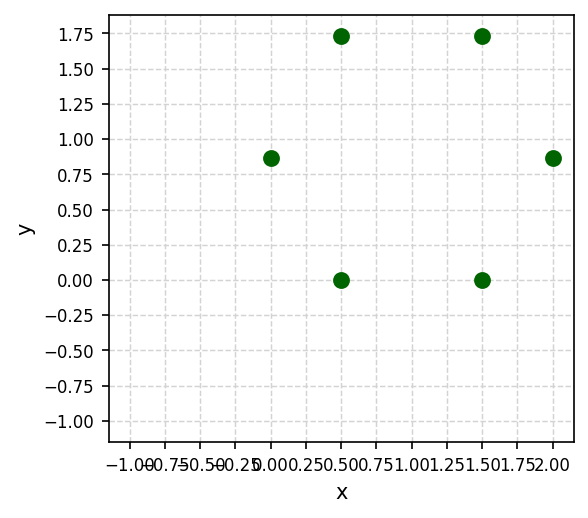

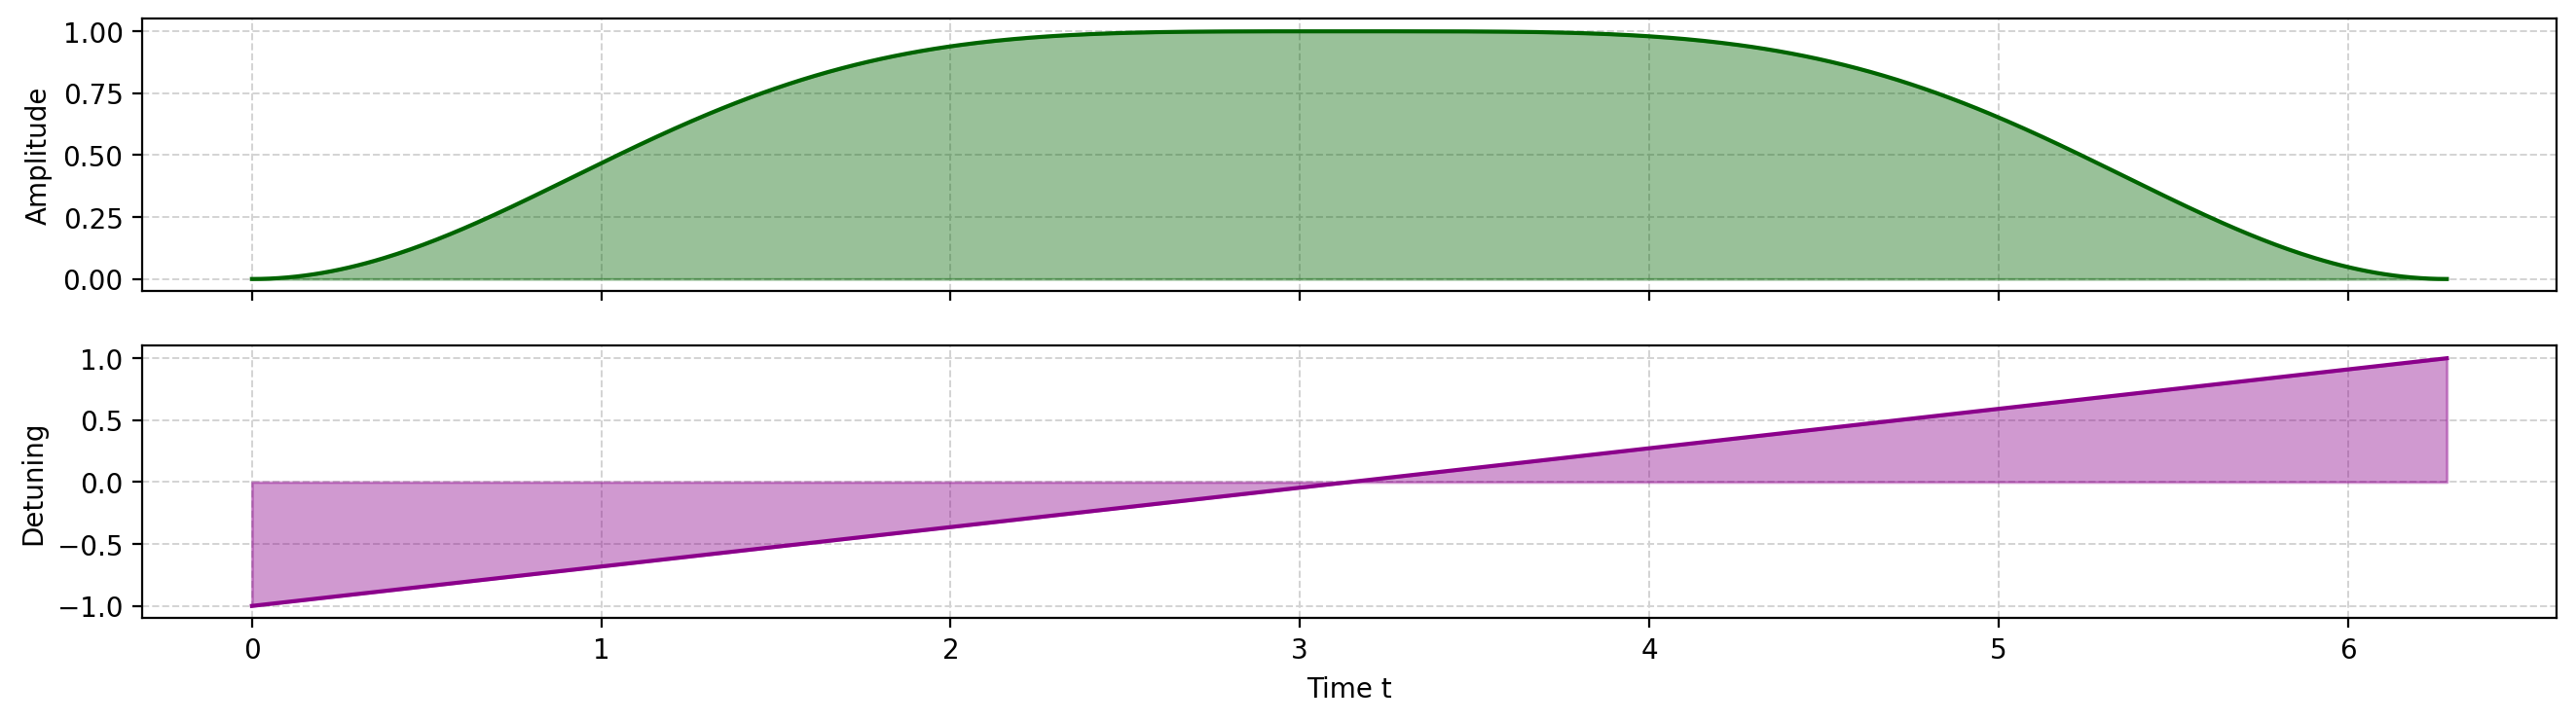

In [34]:
from qoolqit import Drive, QuantumProgram, Ramp

T1 = 2*math.pi # Duration
amp_1 = SmoothPulse(T1, omega_max=1) # amplitude drive
det_1 = Ramp(T1, -1, 1) # detuning drive
drive_1=Drive(amplitude=amp_1, detuning=det_1) # definine the drive
program = QuantumProgram(reg, drive_1) # define the quantum program
program.register.draw() # draw the register
program.draw() # draw the drive

## 4. Compile to a device

To run the QuantumProgram we have to compile it to switch back to physical units that are compatible with a given device.
The now compiled sequence and the compiled register are measured in Pulser units. 
In the compilation it is also possible to select CompilerProfiles to force specific compilation constraints [<a href="https://pasqal-io.github.io/qoolqit/latest/contents/programs/#compiler-profiles"> documentation </a>]

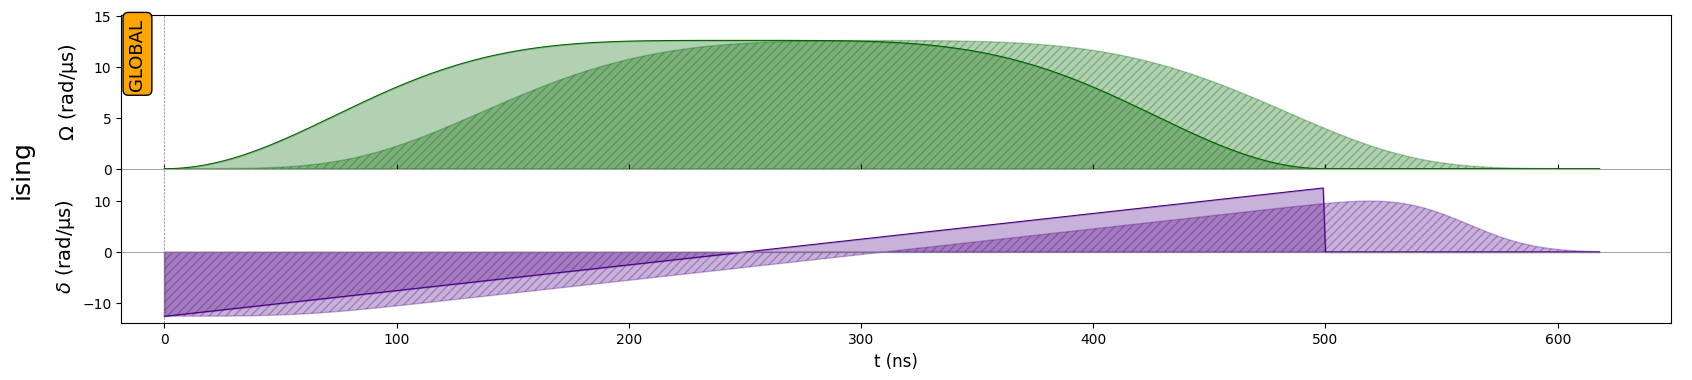

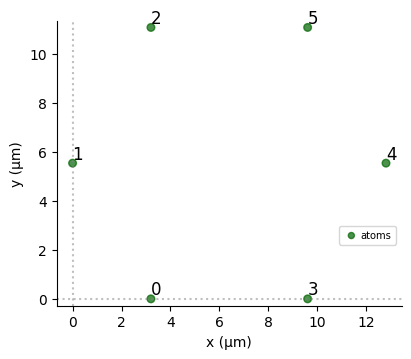

In [35]:
from qoolqit import AnalogDevice

device=AnalogDevice() #Call the device 
program.compile_to(device) #Compile to a device
program.compiled_sequence.draw()
program.compiled_sequence.register.draw()

## 5. Execute the compiled quantum program

In [36]:
from qoolqit.execution import LocalEmulator

# runs specifies the number of bitstrings sample
emulator = LocalEmulator(runs=1000)
results =  emulator.run(program)

counter = results[0].final_bitstrings

## 6. Plot bitstring distribution

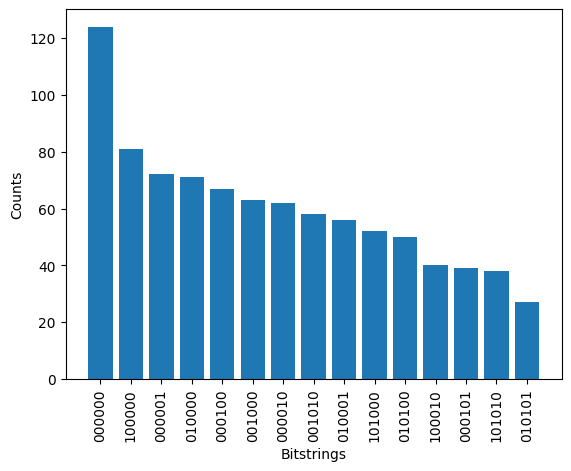

In [37]:
import matplotlib.pyplot as plt


def plot_distribution(counter, bins=15):
    counter = dict(counter.most_common(bins))
    fig, ax = plt.subplots()
    ax.set_xlabel("Bitstrings")
    ax.set_ylabel("Counts")
    ax.set_xticks(range(len(counter)))
    ax.set_xticklabels(counter.keys(), rotation=90)
    ax.bar(range(len(counter.keys())), counter.values(), tick_label=counter.keys())
    return fig

fig = plot_distribution(counter, bins=15)